In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal as ps
import pysal.lib.weights as weights
import pysal.lib.cg as cg
import access

from sklearn.preprocessing import MinMaxScaler

from geopy.distance import distance,geodesic
import aceso

GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
def get_coord_via_PSGC(psgc,df,psgc_col="Bgy_Code",coord_col="centroid"):
    cond = df[psgc_col].astype(str).str.contains(str(psgc))
    lon = df.loc[cond,coord_col].x.values[0]
    lat = df.loc[cond,coord_col].y.values[0]
    return (lat,lon)

def to_coord_tuple(point):
    lon = point.x
    lat = point.y
    return (lat,lon)

def get_PSGC_via_index(index,df,col):
    return df.loc[index,col]

def get_coord_values_in(index,df,col):
    lon = df.loc[index,col].x
    lat = df.loc[index,col].y
    return (lat,lon)

def get_km_dist_two_coord_series(coords1,coords2):
    dists = []
    for coord1,coord2 in zip(coords1,coords2):
        dists.append(geodesic(coord1,coord2).km)
    return dists

In [3]:
crs_constant = "EPSG:4326"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
brgys_geodata = brgys_geodata.to_crs(crs_constant)

cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)

brgys_geodata["centroid"] = brgys_geodata["geometry"].centroid
print("brgys_geodata",brgys_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
schools_geodata = schools_geodata.to_crs(crs_constant)
schools_geodata.dropna(subset=["PSGC_BRGY"],inplace=True)

cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond].reset_index(drop=True)
print("schools_geodata",schools_geodata.shape)

pop_brgy = pd.read_csv(OUTPUT_PATH+"CleanData_Population_Schools_SDGs.csv")
pop_brgy = pop_brgy[["PSGC_BRGY","both_age_6_to_16"]]
print("pop_brgy",pop_brgy.shape)

brgys = brgys_geodata[["Bgy_Code","Pro_Name","geometry"]]
brgys = pd.merge(brgys,pop_brgy,left_on="Bgy_Code",right_on="PSGC_BRGY",how="left")
brgys = brgys[["PSGC_BRGY","Pro_Name","geometry","both_age_6_to_16"]]
print("brgys",brgys.shape)

schools = schools_geodata[["SCH_ID","PSGC_BRGY","PROV","geometry"]]
schools.dropna(subset=["PSGC_BRGY"],inplace=True)
print("schools",schools.shape)

brgys_geodata (2489, 10)
schools_geodata (2533, 13)
pop_brgy (2482, 2)
brgys (2489, 4)
schools (2533, 4)


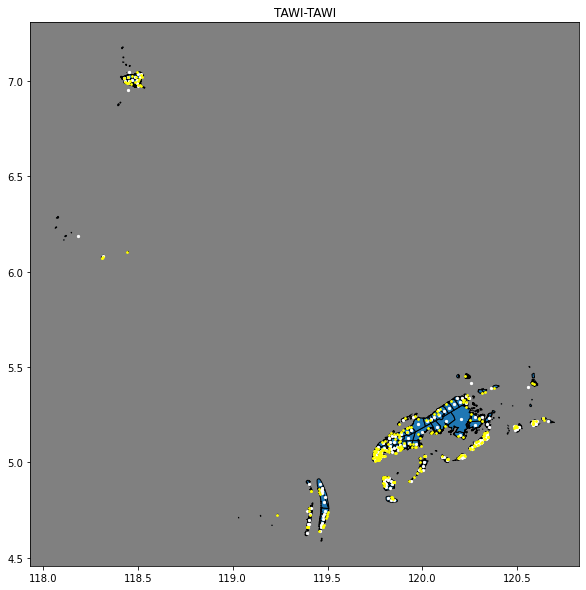

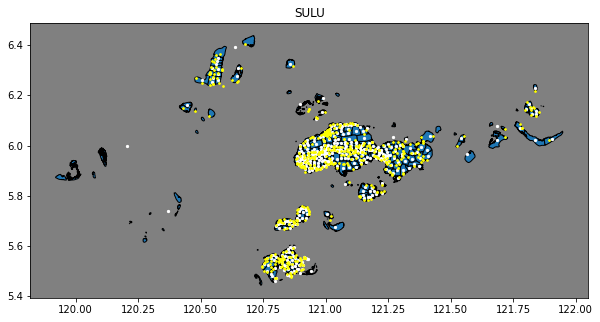

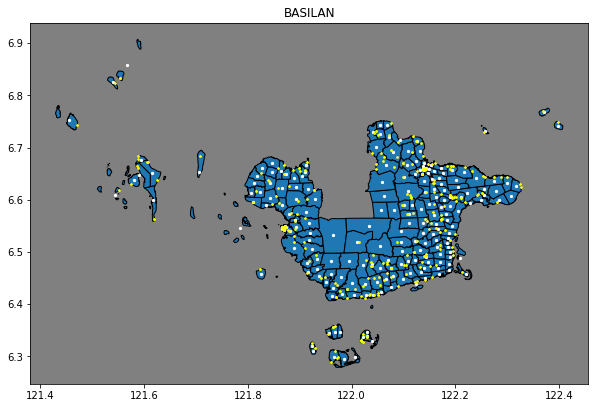

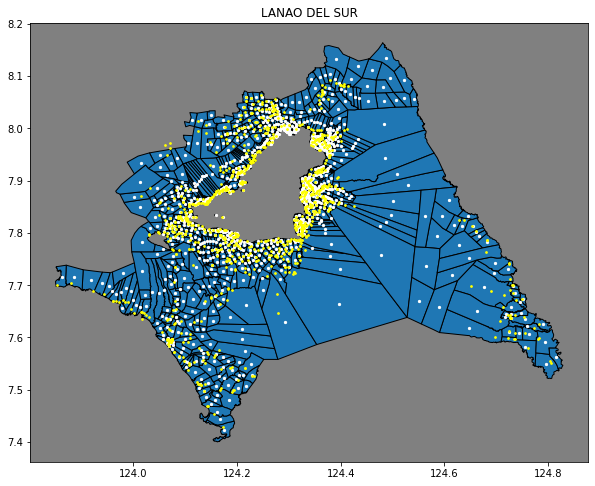

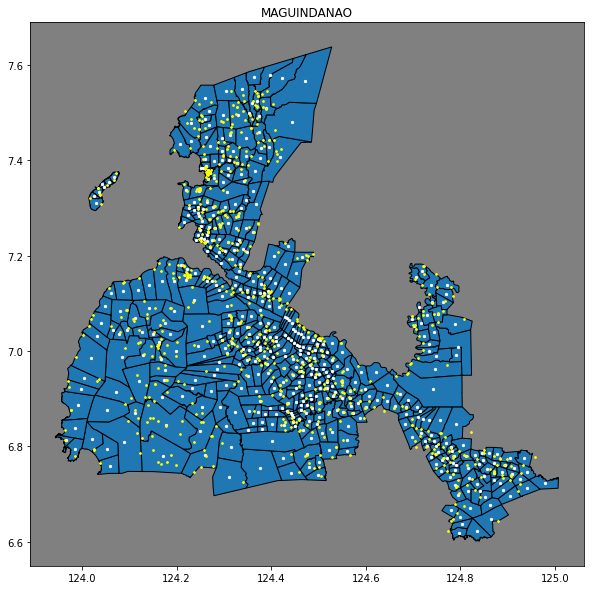

In [4]:
for province in brgys_geodata['Pro_Name'].unique():
    cond1 = brgys_geodata['Pro_Name']==province
    base = brgys_geodata[cond1].plot(figsize=(10,10),edgecolor='k')
    brgys_geodata.loc[cond1,"centroid"].plot(ax=base,color="white",markersize = 5)
    
    cond2 = schools_geodata['PROV']==province
    schools_geodata[cond2].plot(ax=base,color="Yellow",markersize = 3)
    
    plt.title(province)
    base.set_facecolor('grey');

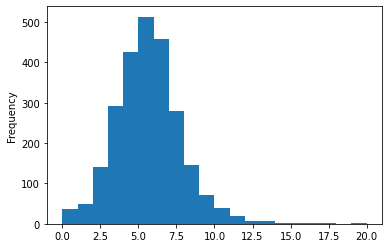

In [5]:
queen_spatial_weights = weights.contiguity.Queen.from_dataframe(brgys_geodata)
pd.Series(queen_spatial_weights._cardinalities).plot.hist(bins=20)
plt.show();

In [6]:
brgy_neighbors = queen_spatial_weights.neighbors
brgy_source_targets = pd.DataFrame()
for source,targets in brgy_neighbors.items():
    if(len(targets)==0):
        targets=[source]
    brgy = {"source_index":source,"target_index":targets}
    brgy_source_targets = brgy_source_targets.append(pd.DataFrame(brgy))
brgy_source_targets["source_PSGC"] = brgy_source_targets["source_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
brgy_source_targets["target_PSGC"] = brgy_source_targets["target_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
brgy_source_targets["source_coords"] = brgy_source_targets["source_index"]\
                                        .apply(get_coord_values_in,df=brgys_geodata,col="centroid")
print("brgy_source_targets",brgy_source_targets.shape)

psgc_search_df = brgy_source_targets.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
cond = psgc_search_df["source_PSGC"]==psgc_search_df["target_PSGC"]
psgc_search_df.loc[~cond,"target_PSGC"] = psgc_search_df.loc[~cond,"source_PSGC"]+"|"+psgc_search_df.loc[~cond,"target_PSGC"]
print("psgc_search_df",psgc_search_df.shape)

school_source_targets = pd.DataFrame()
no_schools_source = []
for source,targets in psgc_search_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)

    if (sum(cond))==0:
        no_schools_source.append(source)
        continue

    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    school_source_targets = school_source_targets.append(_sub_df)

print(len(no_schools_source),"Brgys with No schools even in neighboring Brgys")
school_source_targets = school_source_targets.reset_index(drop=True)
print("school_source_targets",school_source_targets.shape)

school_source_targets["source_coords"] = school_source_targets["source_PSGC"]\
                                            .apply(get_coord_via_PSGC,df=brgys_geodata)

school_source_targets["target_coords"] = school_source_targets["geometry"].apply(to_coord_tuple)

school_source_targets["km_distance"] = get_km_dist_two_coord_series(school_source_targets["source_coords"],
                                                                    school_source_targets["target_coords"])
print("school_source_targets",school_source_targets.shape)
cols = ["source_PSGC","SCH_ID","km_distance"]
distance_matrix = school_source_targets[cols]
distance_matrix = distance_matrix.drop_duplicates().reset_index(drop=True)
print("distance_matrix",distance_matrix.shape)

distance_demand_matrix = pd.DataFrame(columns=["PSGC_BRGY"]+distance_matrix["SCH_ID"].unique().tolist())
distance_demand_matrix["PSGC_BRGY"]=brgys["PSGC_BRGY"]
distance_demand_matrix = distance_demand_matrix.set_index("PSGC_BRGY")

for index in range(len(distance_matrix)):
    try:
        distance_demand_matrix.loc[distance_matrix.loc[index,"source_PSGC"],
                        distance_matrix.loc[index,"SCH_ID"]] = distance_matrix.loc[index,"km_distance"]
    except:
        continue
print("distance_demand_matrix",distance_demand_matrix.shape)

brgy_source_targets (12910, 5)
psgc_search_df (2489, 2)
60 Brgys with No schools even in neighboring Brgys
school_source_targets (15522, 5)
school_source_targets (15522, 8)
distance_matrix (15369, 3)
distance_demand_matrix (2489, 2504)


In [7]:
access_scores_df = brgys[["PSGC_BRGY","both_age_6_to_16"]]
model = aceso.TwoStepFCA(radius=10) # 10km
access_scores_df["Access_Scores_Queen"] = model.calculate_accessibility_scores(
    distance_matrix=distance_demand_matrix,
    demand_array=access_scores_df["both_age_6_to_16"].values
)

access_scores_df["Access_Scores_Queen (distance only)"] = model.calculate_accessibility_scores(
    distance_matrix=distance_demand_matrix,
)

In [8]:
minmax = MinMaxScaler()
access_scores_df["Access_Scores_Queen"] = minmax.fit_transform(access_scores_df[["Access_Scores_Queen"]])
print("access_scores_df",access_scores_df.shape)
access_scores_df.to_csv(OUTPUT_PATH+"Model_Access_Scores_General.csv",index=False)
access_scores_df.head()

access_scores_df (2489, 4)


,PSGC_BRGY,both_age_6_to_16,Access_Scores_Queen,Access_Scores_Queen (distance only)
0,PH157001001,1610.0,0.126741,1.909524
1,PH157001002,874.0,0.129649,1.515909
2,PH157001003,1248.0,0.323160,3.526190
3,PH157001004,525.0,0.166564,1.416667
4,PH157001005,609.0,0.174893,1.833333


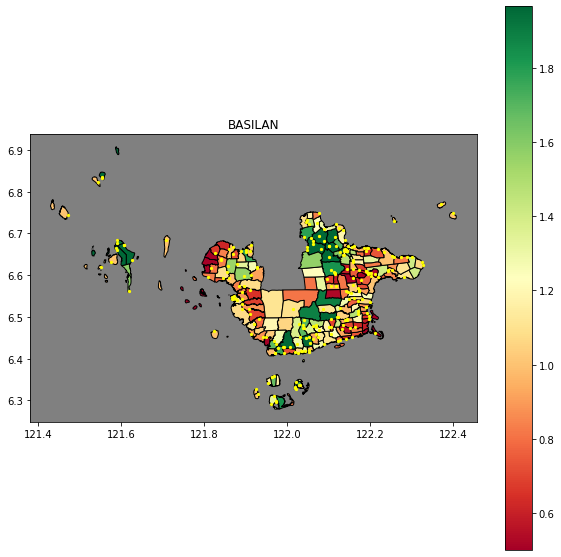

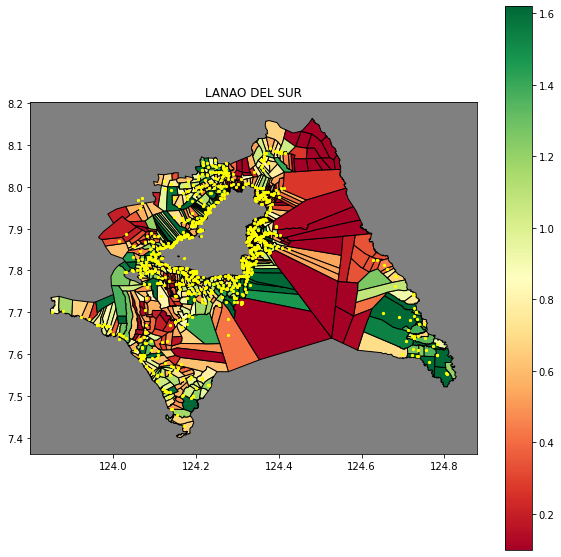

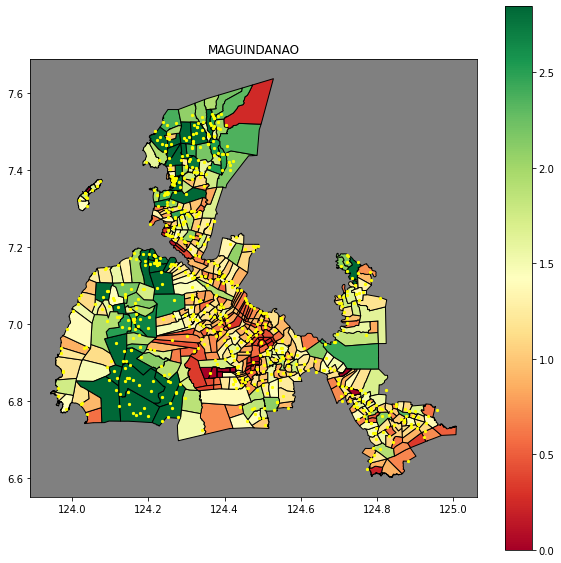

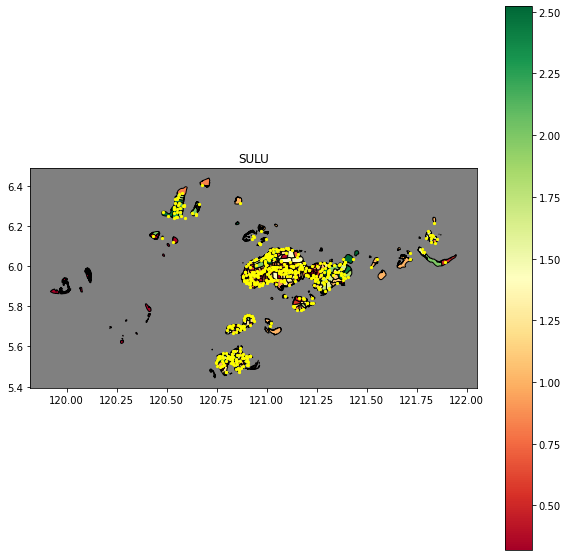

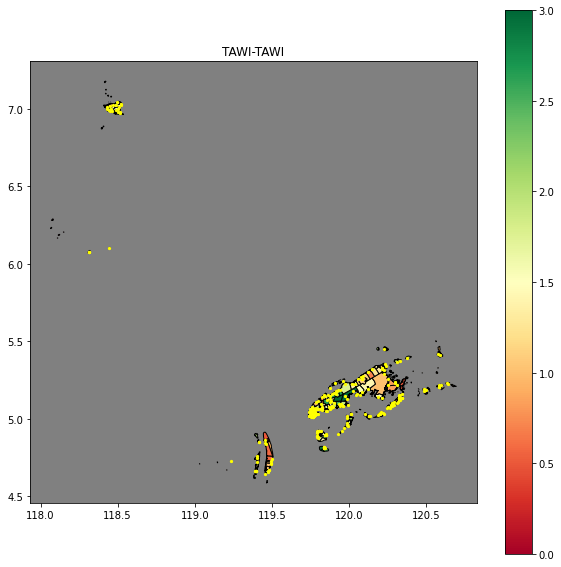

In [9]:
map_object = brgys[["PSGC_BRGY","Pro_Name","geometry"]].set_index('PSGC_BRGY')\
            .join(access_scores_df.set_index('PSGC_BRGY'), how = "inner")
for province in map_object['Pro_Name'].unique():
    cond1 = map_object['Pro_Name']==province
    base = map_object[cond1].plot("Access_Scores_Queen (distance only)", figsize = (10, 10),
                            alpha = 1,edgecolor='k',cmap="RdYlGn", legend=True,
                            vmin = map_object.loc[cond1,"Access_Scores_Queen (distance only)"].quantile(0.05),
                            vmax = map_object.loc[cond1,"Access_Scores_Queen (distance only)"].quantile(0.95))
    cond2 = schools['PROV']==province
    schools[cond2].plot(ax=base,color="Yellow",markersize = 5)
    plt.title(province)
    base.set_facecolor('grey');

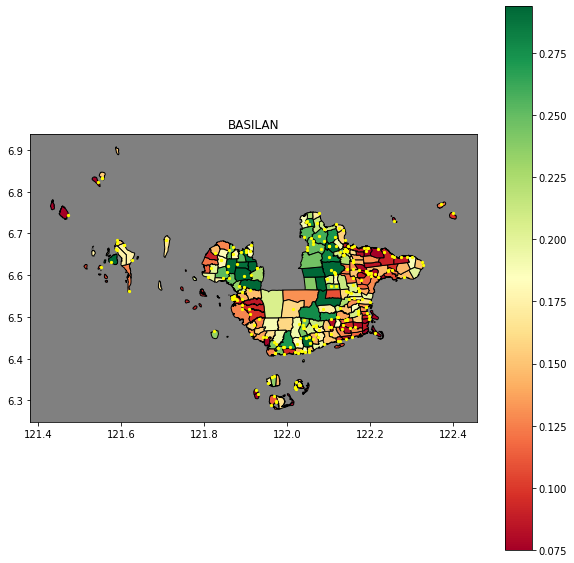

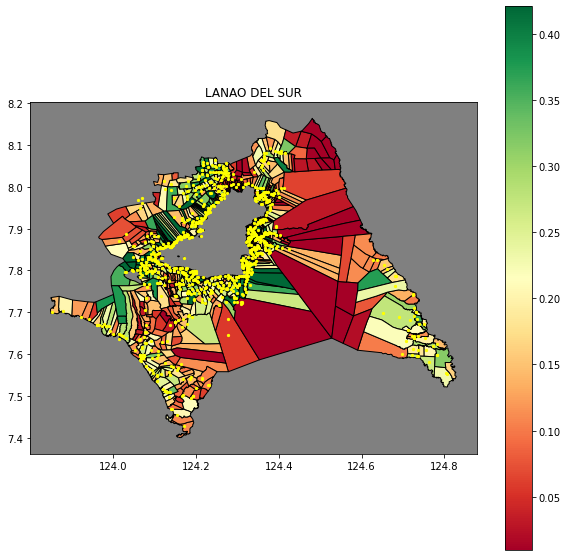

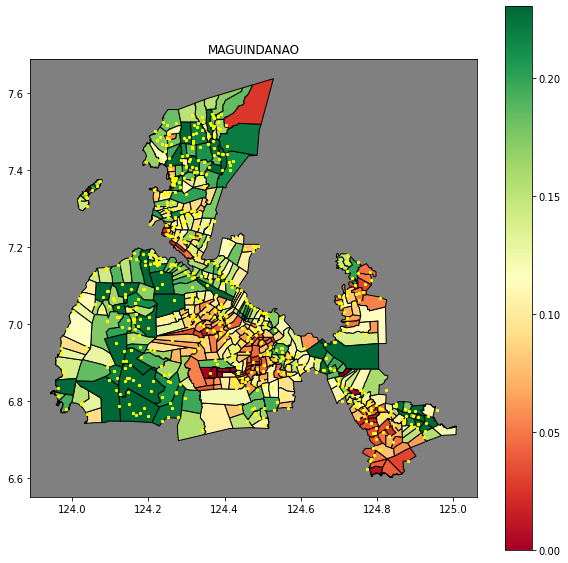

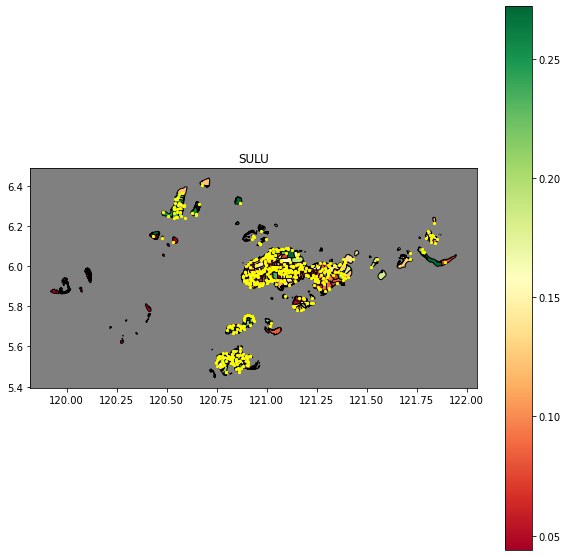

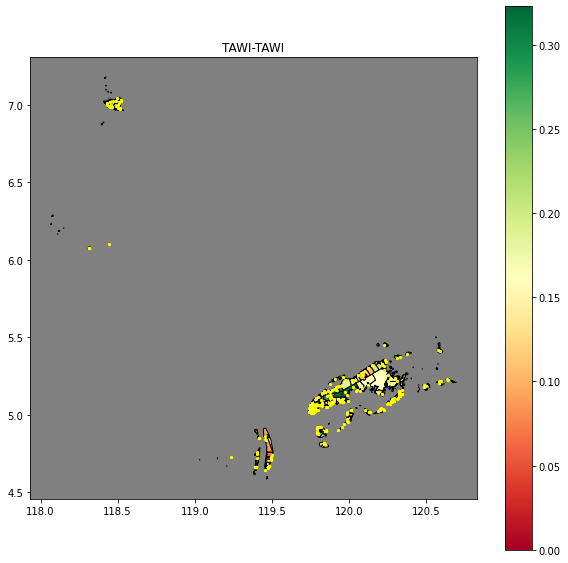

In [10]:
map_object = brgys[["PSGC_BRGY","Pro_Name","geometry"]].set_index('PSGC_BRGY')\
            .join(access_scores_df.set_index('PSGC_BRGY'), how = "inner")
for province in map_object['Pro_Name'].unique():
    cond1 = map_object['Pro_Name']==province
    base = map_object[cond1].plot("Access_Scores_Queen", figsize = (10, 10),
                            alpha = 1,edgecolor='k',cmap="RdYlGn", legend=True,
                            vmin = map_object.loc[cond1,"Access_Scores_Queen"].quantile(0.05),
                            vmax = map_object.loc[cond1,"Access_Scores_Queen"].quantile(0.95))
    cond2 = schools['PROV']==province
    schools[cond2].plot(ax=base,color="Yellow",markersize = 5)
    plt.title(province)
    base.set_facecolor('grey');

Visualization for the Pitch Deck

In [11]:
cond = brgys_geodata["Pro_Name"]=="MAGUINDANAO"
brgys_geodata_maguindanao = brgys_geodata[cond].reset_index(drop=True)
queen_spatial_weights_maguindanao = weights.contiguity.Queen.from_dataframe(brgys_geodata_maguindanao)

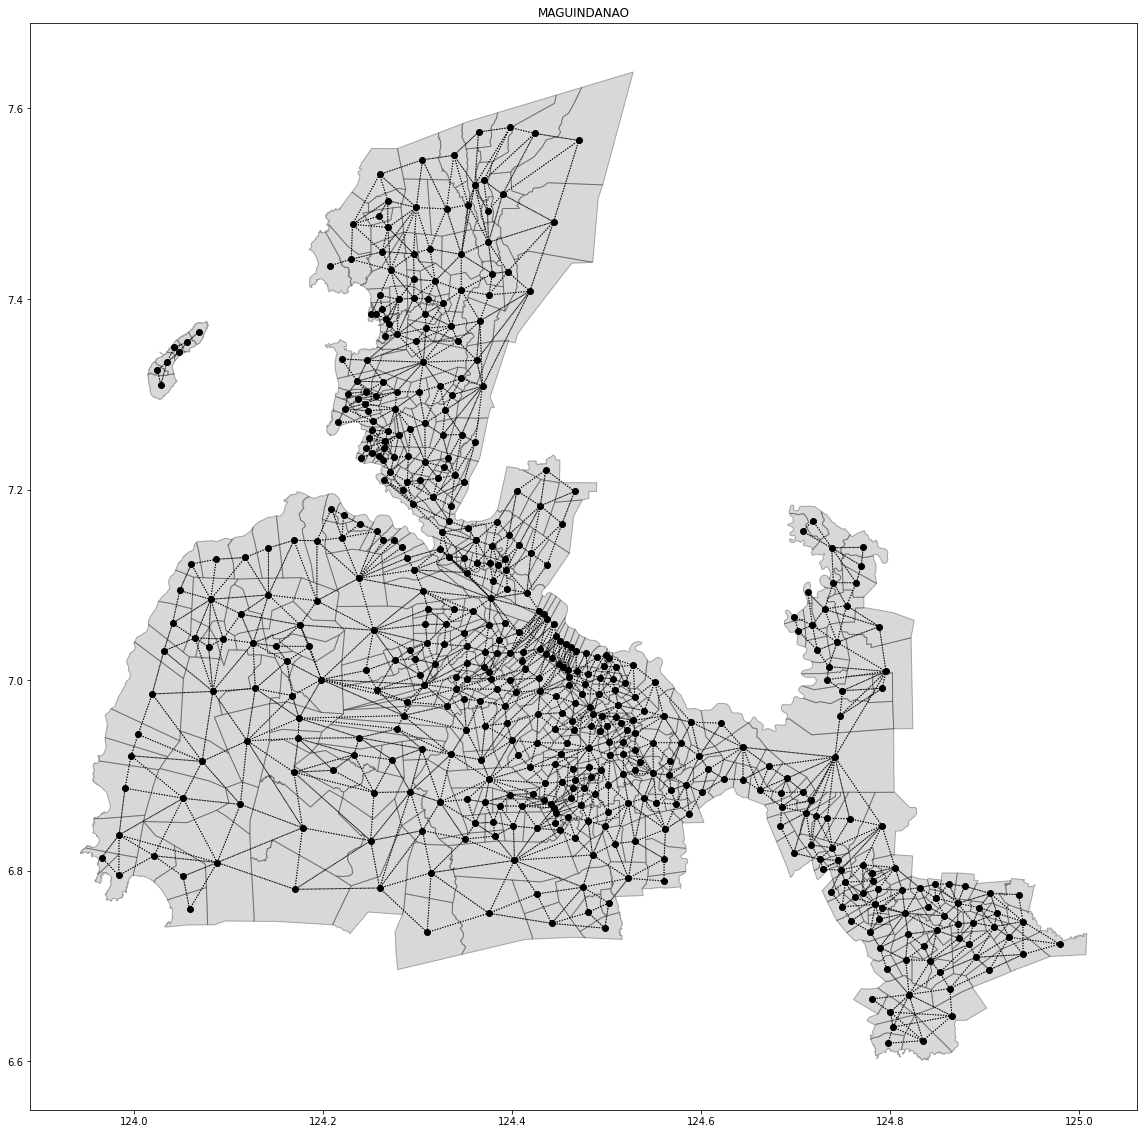

In [12]:
base = brgys_geodata_maguindanao.plot(figsize=(20,20),color="grey", edgecolor='k',alpha=.30)
queen_spatial_weights_maguindanao.plot(brgys_geodata_maguindanao, ax=base, 
        edge_kws=dict(color='Black', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
brgys_geodata_maguindanao["centroid"].plot(ax=base,color="Black")
plt.title("MAGUINDANAO")
plt.show()

In [13]:
brgy_neighbors = queen_spatial_weights_maguindanao.neighbors
brgy_source_targets = pd.DataFrame()
for source,targets in brgy_neighbors.items():
    if(len(targets)==0):
        targets=[source]
    brgy = {"source_index":source,"target_index":targets}
    brgy_source_targets = brgy_source_targets.append(pd.DataFrame(brgy))
brgy_source_targets["source_PSGC"] = brgy_source_targets["source_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata_maguindanao,col="Bgy_Code")
brgy_source_targets["target_PSGC"] = brgy_source_targets["target_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata_maguindanao,col="Bgy_Code")
brgy_source_targets["source_coords"] = brgy_source_targets["source_index"]\
                                        .apply(get_coord_values_in,df=brgys_geodata_maguindanao,col="centroid")
print("brgy_source_targets",brgy_source_targets.shape)

psgc_search_df = brgy_source_targets.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
cond = psgc_search_df["source_PSGC"]==psgc_search_df["target_PSGC"]
psgc_search_df.loc[~cond,"target_PSGC"] = psgc_search_df.loc[~cond,"source_PSGC"]+"|"+psgc_search_df.loc[~cond,"target_PSGC"]
print("psgc_search_df",psgc_search_df.shape)

#manual PSGC_BRGY changes
cond = schools["SCH_ID"]==408895
schools.loc[cond,"PSGC_BRGY"]="PH153822006"

school_source_targets = pd.DataFrame()
no_schools_source = []
for source,targets in psgc_search_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)

    if (sum(cond))==0:
        no_schools_source.append(source)
        continue

    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    school_source_targets = school_source_targets.append(_sub_df)

print(len(no_schools_source),"Brgys with No schools even in neighboring Brgys")
school_source_targets = school_source_targets.reset_index(drop=True)
print("school_source_targets",school_source_targets.shape)

school_source_targets["source_coords"] = school_source_targets["source_PSGC"]\
                                            .apply(get_coord_via_PSGC,df=brgys_geodata_maguindanao)

school_source_targets["target_coords"] = school_source_targets["geometry"].apply(to_coord_tuple)

school_source_targets["km_distance"] = get_km_dist_two_coord_series(school_source_targets["source_coords"],
                                                                    school_source_targets["target_coords"])
print("school_source_targets",school_source_targets.shape)
cols = ["source_PSGC","SCH_ID","km_distance"]
distance_matrix = school_source_targets[cols]
distance_matrix = distance_matrix.drop_duplicates().reset_index(drop=True)
print("distance_matrix",distance_matrix.shape)

distance_demand_matrix = pd.DataFrame(columns=["PSGC_BRGY"]+distance_matrix["SCH_ID"].unique().tolist())
distance_demand_matrix["PSGC_BRGY"]=brgys["PSGC_BRGY"]
distance_demand_matrix = distance_demand_matrix.set_index("PSGC_BRGY")

for index in range(len(distance_matrix)):
    try:
        distance_demand_matrix.loc[distance_matrix.loc[index,"source_PSGC"],
                        distance_matrix.loc[index,"SCH_ID"]] = distance_matrix.loc[index,"km_distance"]
    except:
        continue
print("distance_demand_matrix",distance_demand_matrix.shape)

brgy_source_targets (2816, 5)
psgc_search_df (507, 2)
1 Brgys with No schools even in neighboring Brgys
school_source_targets (4385, 5)
school_source_targets (4385, 8)
distance_matrix (4345, 3)
distance_demand_matrix (2489, 658)


In [14]:
distance_matrix["brgy_centroid"] = distance_matrix["source_PSGC"].apply(get_coord_via_PSGC,df=brgys_geodata_maguindanao)

distance_matrix["school_coords"] = distance_matrix["SCH_ID"].apply(get_coord_via_PSGC,df=schools,
                                                                   psgc_col="SCH_ID",coord_col="geometry")
distance_matrix[["centroid_lat","centroid_lon"]] = distance_matrix["brgy_centroid"].astype(str)\
                                                    .str.replace("\)","")\
                                                    .str.replace("\(","")\
                                                    .str.split(", ",expand=True)
distance_matrix[["school_lat","school_lon"]] = distance_matrix["school_coords"].astype(str)\
                                                    .str.replace("\)","")\
                                                    .str.replace("\(","")\
                                                    .str.split(", ",expand=True)
change_cols = ["school_lat","school_lon"]+["centroid_lat","centroid_lon"]
for col in change_cols:
    distance_matrix[col]=distance_matrix[col].astype(float)
    
distance_matrix.drop(columns=["brgy_centroid","school_coords"],inplace=True)
distance_matrix.head()

,source_PSGC,SCH_ID,km_distance,centroid_lat,centroid_lon,school_lat,school_lon
0,PH153801004,133875,1.435922,6.834807,124.466809,6.843938,124.476045
1,PH153801004,133877,0.954753,6.834807,124.466809,6.832546,124.458473
2,PH153801004,216652,2.456130,6.834807,124.466809,6.855753,124.459422
3,PH153801004,216546,2.132053,6.834807,124.466809,6.829296,124.485293
4,PH153801004,304999,0.715835,6.834807,124.466809,6.833090,124.460565


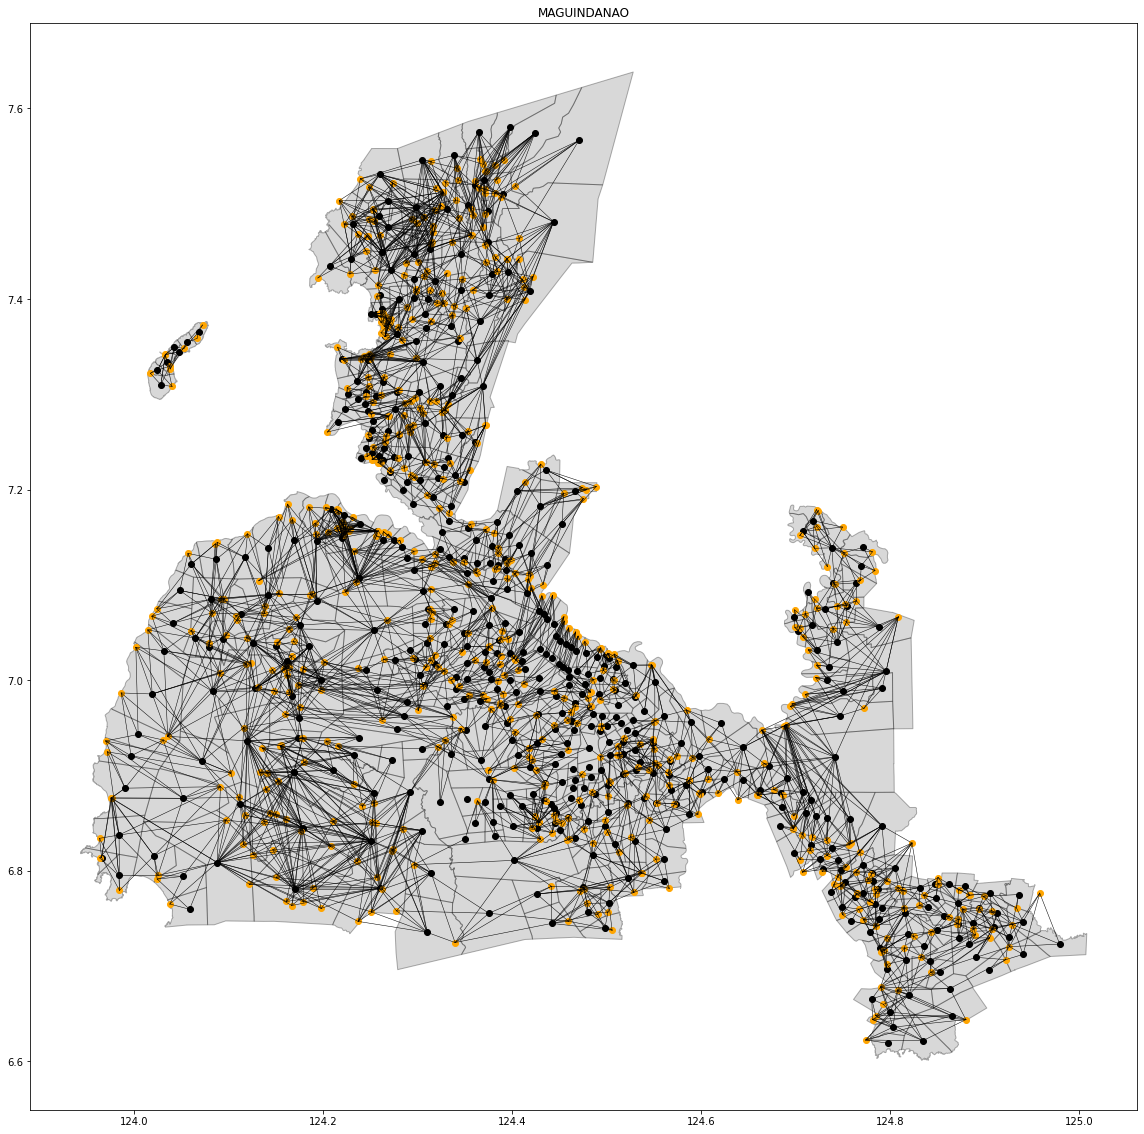

In [15]:
base = brgys_geodata_maguindanao.plot(figsize=(20,20),color="grey", edgecolor='k',alpha=.3)
brgys_geodata_maguindanao["centroid"].plot(ax=base,color="Black")
cond2 = schools['PROV']=="MAGUINDANAO"
schools[cond2].plot(ax=base,color="orange")
for index in range(len(distance_matrix)):
    x1 = distance_matrix.loc[index,'centroid_lon']
    y1 = distance_matrix.loc[index,'centroid_lat']
    x2 = distance_matrix.loc[index,'school_lon']
    y2 = distance_matrix.loc[index,'school_lat']
    plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.5)

plt.title("MAGUINDANAO")
plt.show()